## Darcy Flow Equation 2D

The steady-state of the 2-d Darcy Flow equation on the unit box which is the second order, linear, elliptic PDE

\begin{equation}
    -\nabla \cdot(a\nabla u) = f, in~\text{D}  \\ 
    u|_{\partial D} = 0 
\end{equation}

with a Dirichlet boundary where $a \in L^\infty ((0, 1)^2; R_{+})$ is the diffusion coefficient and $ f \in L^{2}((0, 1)^2; R)$ is the forcing function. This PDE has numerous applications including modeling the pressure of subsurface flow, the deformation of linearly elastic materials, and the electric potential in conductive materials. The operator mapping the diffusion coefficient to the solution,  defined by $G^{*} : a \rightarrow u$. Note that although the PDE is linear, the operator $G^*$ is not.

Forcing term is set to $f = 1$ and diffusion coefficient $a \sim \psi \neq \mu$, with $\mu$ being a Gaussian Process with zero mean and squared exponential kernel

\begin{equation}
    k(x,y) = \sigma^{2} \exp \left( \frac{|x-y|^2}{l^2} \right),~ \sigma^{2}=0.1
\end{equation}

We chose the length scale $l = 0.1$ for the in-distribution testing and $l = 0.05$ for the out-of-distribution testing. The mapping $\psi : R \rightarrow R$ takes the value 12 on the positive part of the real line and 3 on the negative part. 

## Wave Equation 2D

Linear Hyperbolic PDE

\begin{equation}
    u_{tt} -c^2\nabla^{2} u = 0, \text{in} ~ D \times (0,T),~u_{0}(x,y) = f(x,y) \\
    f(x,y) = \frac{\pi}{K^2} \Sigma_{i,j=1}^{K} a_{ij}(i^2 + j^2)^{-r} \cdot \sin(\pi i x)sin(\pi jy), \forall (x,y) \in D
\end{equation}

with a constant propagation speed $c = 0.1$. The underlying operator $G^* : f \rightarrow u(., T )$ maps the initial condition f with r= 1 into the solution at the final time. The training and in-distribution test samples are generated by setting T = 5, K = 24 and $a_{ij}$ to be i.i.d. uniformly distributed from $[−1, 1] $.For out-of-distribution testing, the exponent r = 0.85 and K = 32.

Exact Solution at $t>0$

\begin{equation}
    u(x,y,t) = \frac{\pi}{K^2} \Sigma_{i,j=1}^{K} a_{ij}(i^2 + j^2)^{-r} \cdot \sin(\pi i x)sin(\pi jy) \cos\left(c\pi t\sqrt{i^2+j^2}\right), \forall (x,y) \in D
\end{equation}


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import pandas as pd
from tqdm import tqdm
import h5py
import math
import copy
import scipy
import pickle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as Func
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

%matplotlib inline

## Wave and Darcy Data

In [3]:
file = "/p/project/cexalab/john2/NeuralOperators/neural_operators/data/Darcy_64x64_IN.h5"
# file = "/p/project/cexalab/john2/NeuralOperators/neural_operators/data/WaveData_64x64_IN.h5"
example = "darcy"
with h5py.File(file, "r") as f:
    
    if example == "wave":
        # t={1:10}
        # input same for all t={1:10}
        # index = {0:1999}
        # keys = 2000 + 8
        # input: u(t=0), output: u(t>0)
        t1 = 1
        t2 = 5
        index1 = 1
        index2 = 100
        x1 = torch.from_numpy(f["Sample_" + str(index1) + "_t_" + str(t1)]["input"][:]).type(torch.float32)
        y1 = torch.from_numpy(f["Sample_" + str(index1) + "_t_" + str(t1)]["output"][:]).type(torch.float32)
        x2 = torch.from_numpy(f["Sample_" + str(index2) + "_t_" + str(t2)]["input"][:]).type(torch.float32)
        y2 = torch.from_numpy(f["Sample_" + str(index2) + "_t_" + str(t2)]["output"][:]).type(torch.float32)
    else:
        # index = {0:512}
        # keys  = 512 + 5
        # input: a(x), output: u(x)
        index1 = 1
        index2 = 100
        x1 = torch.from_numpy(f["sample_" + str(index1)]["input"][:]).type(torch.float32)
        y1 = torch.from_numpy(f["sample_" + str(index1)]["output"][:]).type(torch.float32)
        x2 = torch.from_numpy(f["sample_" + str(index2)]["input"][:]).type(torch.float32)
        y2 = torch.from_numpy(f["sample_" + str(index2)]["output"][:]).type(torch.float32)
    
    print("Shape:",x1.shape, y1.shape)
    print(f"Index at {index1} with input {x1} and output{y1}")
    print(f"Index at {index2} with input {x2} and output{y2}")
    print(f"Difference in input at index {index1} and index {index2} is {np.linalg.norm(x1-x2)}")
    print(f"Difference in output at index {index1} and index {index2} is {np.linalg.norm(y1-y2)}")
f.close()

In [19]:
def default_param(network_properties):
    
    if "modes1" not in network_properties:
        network_properties["modes1"] = 16
        
    if "modes2" not in network_properties:
        network_properties["modes2"] = 16
    
    if "width" not in network_properties:
        network_properties["width"] = 32
    
    if "n_layers" not in network_properties:
        network_properties["n_layers"] = 4
        
    if "proj_scale" not in network_properties:
        network_properties["proj_scale"] = 32

    if "padding" not in network_properties:
        network_properties["padding"] = 0
    
    if "include_grid" not in network_properties:
        network_properties["include_grid"] = 1
    
    if "FourierF" not in network_properties:
        network_properties["FourierF"] = 0
    
    return network_properties


def default_train_params(training_properties):
    if "learning_rate" not in training_properties:
        training_properties["learning_rate"] = 0.001
        
    if "weight_deacy" not in training_properties:
        training_properties["weight_decay"] = 1e-6
        
    if "scheduler_step" not in training_properties:
        training_properties["scheduler_step"] = 0.98
        
    if "scheduler_gamma" not in training_properties:
        training_properties["scheduler_gamma"] = 10
        
    if "epochs" not in training_properties:
        training_properties["epochs"] = 1000
        
    if "batch_size" not in training_properties:
        training_properties["batch_size"] = 32
        
    if "exp" not in training_properties:
        training_properties["exp"] = 1
        
    if "training_samples" not in training_properties:
        training_properties["training_samples"] = 256
        
    return training_properties


class FourierFeatures(nn.Module):

    def __init__(self, scale, mapping_size, device):
        super().__init__()
        self.mapping_size = mapping_size
        self.scale = scale
        self.B = scale * torch.randn((self.mapping_size, 2)).to(device)  # [mapping_size,2]

    def forward(self, x):
        # x is the set of coordinate and it is passed as a tensor (nx, ny, 2)
        if self.scale != 0:
            x_proj = torch.matmul((2. * np.pi * x), self.B.T) # [nx, ny, 2]*[2,mapping_size] ----> [nx, ny, mapping_size]
            inp = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1) # [nx, ny, 2*mapping_size]
            return inp
        else:
            return x


# 2D Fourier Neural Operator 

In [3]:
################################################################
# 2D Fourier Layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. Performs FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1 
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def complexmulti_2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    #"bixy,ikx->bkxy"
    #"bkxy,koy->boxy"

    def forward(self, x):
        batchsize = x.shape[0]  # (batch, in_channel, x,y )
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        # real FFT is redundant along that last dimension.
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.complexmulti_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.complexmulti_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x




class FNO2d(nn.Module):
    def __init__(self, fno_architecture, in_channels=1, out_channels=1, device="cpu"):
        super(FNO2d, self).__init__()

        """
        The network contains n_layers of the Fourier layer. 
        The following is done:
        1. Lift the input layer to the desire channel dimension by p layer
        2. n layers of the integral operators u' = (W + K)(u).
           W defined by self.w; K defined by self.conv 
        3. Project from the channel space to the output space by q 
        

        input: solution of the initial condition and location (a(x,y), x, y)
        input_shape: (batchsize, x=sx, y=sy, c=3)
        output: solution at a later timestep
        output_shape: (batchsize, x=sx, y=sy, c=1)
        """
        self.modes1 = fno_architecture["modes1"]
        self.modes2 = fno_architecture["modes2"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.proj_scale = fno_architecture["proj_scale"]
        self.padding = fno_architecture["padding"]
        self.input_dim = in_channels
        self.activation  = activation_selection(fno_architecture["activation"])
        self.device = device
        
    
      
        self.p = nn.Sequential(nn.Linear(self.input_dim, self.proj_scale),  # scaling: p layer
                               self.activation,
                               nn.Linear(self.proj_scale, self.width))   
        
     
        self.conv_list = nn.ModuleList([nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)]) # W
        self.spectral_list = nn.ModuleList([SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])  # K

        
        self.q = nn.Sequential(nn.Linear(self.width, self.proj_scale), # projection: q layer 
                                self.activation,
                                nn.Linear(self.proj_scale, out_channels))  
        
        self.to(device)

    def forward(self, x):

        x = self.p(x)
        x = x.permute(0, 3, 1, 2) # (batch_size, x, y, width) ---> (batch_size, width, x, y)
        
        x1_padding =  self.padding
        x2_padding =  self.padding
                
        if self.padding>0: 
            x = Func.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = self.activation(x)
        
        del x1
        del x2
        
        if self.padding > 0:
            x = x[..., :-x1_padding, :-x2_padding]            
        x = x.permute(0, 2, 3, 1)  # (batch_size, width, x, y) ---> (batch_size, x, y, width) 
        x = self.q(x)

        return x

    def print_size(self):
        nparams = 0
        nbytes = 0

        for param in self.parameters():
            nparams += param.numel()
            nbytes += param.data.element_size() * param.numel()

        print(f'Total number of model parameters: {nparams} with {nbytes}(~{format_tensor_size(nbytes)})')

        return nparams
    

# Plot Function for Wave and Darcy

In [4]:
def plot_data(x, y, index, example, z=0, out=False):
    if out:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Input y')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(y.squeeze())
        ax.set_title('Model Prediction')
        fig.suptitle(f'Visualizing sample {index} of {example} problem', y=0.76)
        fig.tight_layout()
        fig.show()
            
    else: 
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Ouput y')
        fig.suptitle(f'Visualizing input sample {index} for {example} problem', y=0.75)
        fig.tight_layout()
        fig.show()

# Wave equation

Sample_0_t_1
<class 'h5py._hl.group.Group'>
input
output
torch.Size([64, 64]) torch.Size([64, 64])


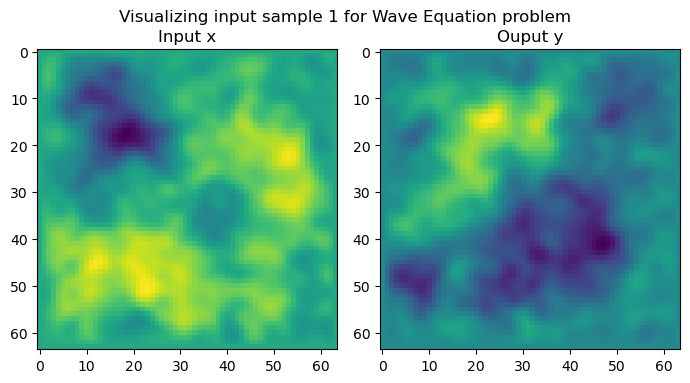

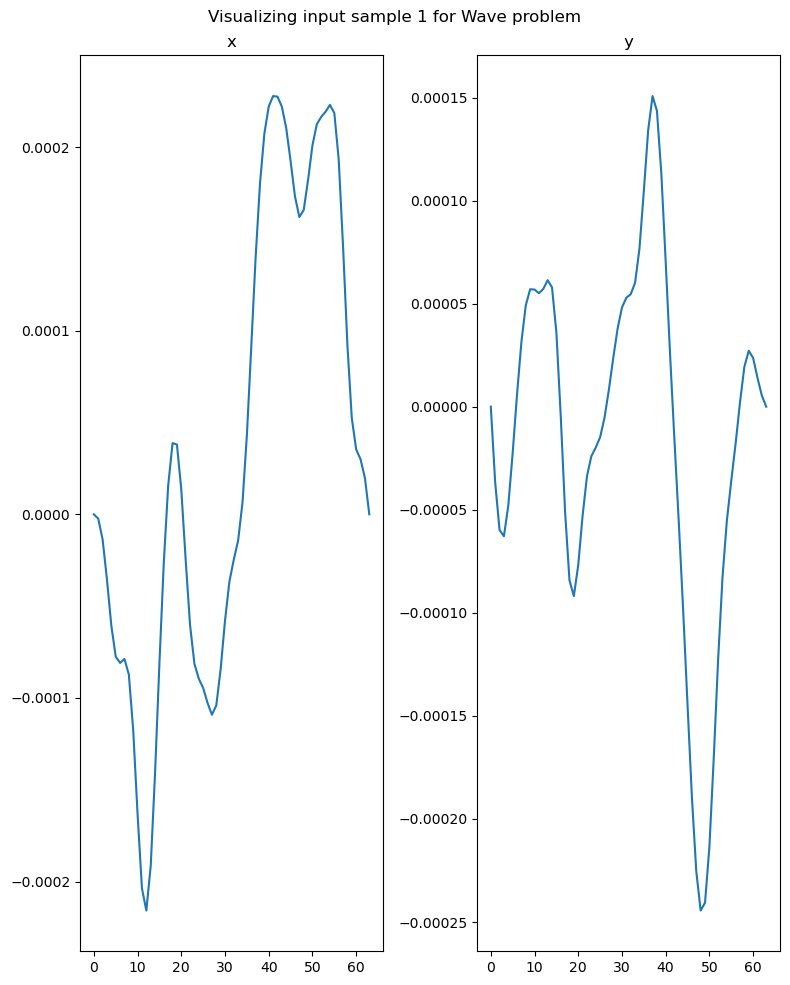

In [6]:
file = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/WaveData_64x64_IN.h5"
with h5py.File(file, "r") as f:
    for key in f.keys():
        print(key) # Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset
        break
    
    
    index = 1
    start = 0 
    t = 5
    #Get the HDF5 group; key needs to be a group name from above
    group = f[key]

    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)

    x = torch.from_numpy(f['Sample_' + str(index + start)+"_t_"+str(t)]["input"][:]).type(torch.float32)
    y = torch.from_numpy(f['Sample_' + str(index + start)+"_t_"+str(t)]["output"][:]).type(torch.float32)
    print(x.shape,y.shape)

plot_data(x.reshape(1, x.shape[0], x.shape[1]), y.reshape(1, y.shape[0], y.shape[1]),index,example="Wave Equation", out=False)

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(1, 2, 1)
plt.plot(x[:,5],label="x")
ax.set_title('x')
ax = fig.add_subplot(1, 2, 2)
plt.plot(y[:,5],label="y")
ax.set_title('y')
fig.suptitle(f'Visualizing input sample {index} for Wave problem')
fig.tight_layout()
fig.show()

## Wave Data Processing

In [16]:
# Wave data:
# From 0 to 512 : training samples (512)
# From 1024 to 1024 + 128 : validation samples (128)
# From 1024 + 128 to 1024 + 128 + 256 : test samples (256)
# Out-of-distribution testing samples: 0 to 256 (256)

class WaveEquationDataset(Dataset):
    def __init__(self, task="training", nf=0, training_samples = 1024, t = 5, s = 64, in_dist = True):
        
        # Data file:       
        if in_dist:
            self.file_data = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/WaveData_64x64_IN.h5"
        else:
            self.file_data = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/WaveData_64x64_IN.h5"

        self.reader = h5py.File(self.file_data, 'r')
        
        # Load normaliation constants:
        self.min_data = self.reader['min_u0'][()]
        self.max_data = self.reader['max_u0'][()]
        self.min_model = self.reader['min_u'][()]
        self.max_model = self.reader['max_u'][()]
        
        # Time
        self.t = t
                        
        if task == "training":
            self.length = training_samples
            self.start = 0
        elif task == "validation":
            self.length = 128
            self.start = 1024
        elif task == "test":
            if in_dist:
                self.length = 256
                self.start = 1024 + 128
            else:
                self.length = 256
                self.start = 0
                
        # Grid size
        self.s = s
        
        #Fourier modes 
        self.N_Fourier_F = nf
        
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['Sample_' + str(index + self.start)+"_t_"+str(self.t)]["input"][:]).type(torch.float32).reshape(1, self.s, self.s)
        labels = torch.from_numpy(self.reader['Sample_' + str(index + self.start)+"_t_"+str(self.t)]["output"][:]).type(torch.float32).reshape(1, self.s, self.s)
        # normalising data 
        inputs = (inputs - self.min_data)/(self.max_data - self.min_data)
        labels = (labels - self.min_model)/(self.max_model - self.min_model)

        if self.N_Fourier_F > 0:
            grid = self.get_grid() # [s, s, 2]
            FF = FourierFeatures(1, self.N_Fourier_F, grid.device)
            # B shape torch.Size([N_Fourier_F, 2])
            # x_proj torch.Size([s, s, N_Fourier_F])
            ff_grid = FF(grid) # [s, s, 2*N_Fourier_F]
            ff_grid = ff_grid.permute(2, 0, 1) #[s, s, 2*N_Fourier_F] ---> [2*N_Fourier_F,s,s]
            inputs = torch.cat((inputs, ff_grid), 0) #([1,s,s],[2*N_Fourier,s,s]) ---> [2*N_Fourier_F+1,s,s]
            

        return inputs.permute(1, 2, 0), labels.permute(1, 2, 0) # [2*N_Fourier_F+1,s,s], [1,s,s] ---> [s,s,2*N_Fourier_F+1], [s,s,1]

    def get_grid(self):
        x = torch.linspace(0, 1, self.s) # [s]
        y = torch.linspace(0, 1, self.s) # [s]

        x_grid, y_grid = torch.meshgrid(x, y) # [s,s]

        x_grid = x_grid.unsqueeze(-1)  # [s,s,1]
        y_grid = y_grid.unsqueeze(-1)  # [s,s,1]
        grid = torch.cat((x_grid, y_grid), -1)  # [s,s,2]
        return grid


class WaveEquation:
    def __init__(self, network_properties, device, batch_size, training_samples = 1024, s = 64, in_dist = True):
        
        network_properties = default_param(network_properties)
        self.N_Fourier_F = network_properties["FourierF"]
    
        
        self.model = FNO2d(fno_architecture = network_properties, 
                            in_channels = 1 + 2 * self.N_Fourier_F, 
                            out_channels = 1, 
                            device=device) 
        num_workers = 8
        
        self.train_loader = DataLoader(WaveEquationDataset("training", self.N_Fourier_F, training_samples, 5, s), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_loader = DataLoader(WaveEquationDataset("validation", self.N_Fourier_F, training_samples, 5, s), batch_size=batch_size, shuffle=False, num_workers=num_workers)
        self.test_loader = DataLoader(WaveEquationDataset("test", self.N_Fourier_F, training_samples, 5, s, in_dist), batch_size=batch_size, shuffle=False, num_workers=num_workers)
        

# Darcy Flow

grid
<class 'h5py._hl.dataset.Dataset'>
input
output
torch.Size([64, 64]) torch.Size([64, 64])


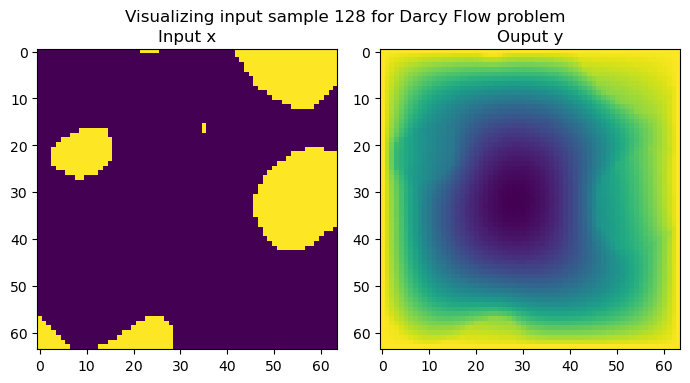

In [8]:
file = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
with h5py.File(file, "r") as f:
    for key in f.keys():
        print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset
        break
    
    
    index = 128
    start = 0 
    #Get the HDF5 group; key needs to be a group name from above
    group = f['sample_' + str(index + start)]

    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)

    x = torch.from_numpy(f['sample_' + str(index + start)]["input"][:]).type(torch.float32)
    y = torch.from_numpy(f['sample_' + str(index + start)]["output"][:]).type(torch.float32)
    print(x.shape,y.shape)
    
plot_data(x.reshape(1, x.shape[0], x.shape[1]), y.reshape(1, y.shape[0], y.shape[1]),index,example="Darcy Flow", out=False)

### Darcy Flow Data Processing

In [17]:
class DarcyDataset(Dataset):
    def __init__(self, task="training", nf=0, training_samples=256, s=64, insample=True):

        if insample:
            self.file_data = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
        else:
            self.file_data = "/p/scratch/cexalab/john2/neural_operators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
        
        
        self.reader = h5py.File(self.file_data, 'r')

        self.min_data = self.reader['min_inp'][()]
        self.max_data = self.reader['max_inp'][()]
        self.min_model = self.reader['min_out'][()]
        self.max_model = self.reader['max_out'][()]
                
        if task == "training":
            self.length = training_samples
            self.start = 0
        elif task == "validation":
            self.length = 128
            self.start = training_samples
        elif task == "testing":
            if insample:
                self.length = 128
                self.start = training_samples + 128
            else:
                self.length = 128
                self.start = 0

        self.N_Fourier_F = nf
        self.s = s

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['sample_' + str(index + self.start)]["input"][:]).type(torch.float32).reshape(1, self.s, self.s)
        labels = torch.from_numpy(self.reader['sample_' + str(index + self.start)]["output"][:]).type(torch.float32).reshape(1, self.s, self.s)
        # normalisation
        inputs = (inputs - self.min_data) / (self.max_data - self.min_data)
        labels = (labels - self.min_model) / (self.max_model - self.min_model)

        if self.N_Fourier_F > 0:
            grid = self.get_grid()  # [s, s, 2*N_Fourier_F]
            FF = FourierFeatures(1, self.N_Fourier_F, grid.device)
             # B shape torch.Size([N_Fourier_F, 2])
            # x_proj torch.Size([s, s, N_Fourier_F])
            ff_grid = FF(grid) # [s, s, 2*N_Fourier_F]
            ff_grid = ff_grid.permute(2, 0, 1)  #[s, s, 2*N_Fourier_F] ---> [2*N_Fourier_F,s,s]
            inputs = torch.cat((inputs, ff_grid), 0) #([1,s,s],[2*N_Fourier,s,s]) ---> [2*N_Fourier_F+1,s,s]

        return inputs.permute(1, 2, 0), labels.permute(1, 2, 0) # [2*N_Fourier_F+1,s,s], [1,s,s] ---> [s,s,2*N_Fourier_F+1], [s,s,1]

    def get_grid(self):
        x = torch.linspace(0, 1, s) # [s]
        y = torch.linspace(0, 1, s) # [s]

        x_grid, y_grid = torch.meshgrid(x, y) # [s,s]

        x_grid = x_grid.unsqueeze(-1) # [s,s,1]
        y_grid = y_grid.unsqueeze(-1)  # [s,s,1]
        grid = torch.cat((x_grid, y_grid), -1)  # [s,s,2]
  
        return grid

class Darcy:
    def __init__(self, network_properties, device, batch_size, training_samples = 512,  s = 64, in_dist = True):
        
        network_properties = default_param(network_properties)
        self.N_Fourier_F = network_properties["FourierF"]
        
        self.model = FNO2d(fno_architecture = network_properties, 
                            in_channels = 1 + 2 * self.N_Fourier_F, 
                            out_channels = 1, 
                            device=device) 
        
        # self.model = FNO1d(fno_architecture = network_properties,
                           # in_channels=2,
                           # out_channels=1,
                           # padding_frac=1/4,
                           # device=device)
                           

        num_workers = 8

        self.train_loader = DataLoader(DarcyDataset("training", self.N_Fourier_F, training_samples), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_loader = DataLoader(DarcyDataset("validation", self.N_Fourier_F, training_samples), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.test_loader = DataLoader(DarcyDataset("testing", self.N_Fourier_F, training_samples, in_dist), batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
  
  

# Defining Hyperparameters: Wave & Darcy

In [10]:
# Chose example
example = "darcy"  #darcy, wave
folder = "/p/scratch/cexalab/john2/NeuralOperators/FNO/TrainModels/"+"FNO_"+example+"_tmp3"
if not os.path.isdir(folder):
    os.mkdir(folder)
    print("Generated new folder")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(log_dir=folder)
network_properties = {}
training_properties = {}
fno_architecture = default_param(network_properties)
training_properties = default_train_params(training_properties)

learning_rate = training_properties["learning_rate"]
training_properties["epochs"] = 100
# epochs = training_properties["epochs"]
batch_size = training_properties["batch_size"]
weight_decay = training_properties["weight_decay"]
scheduler_step = training_properties["scheduler_step"]
scheduler_gamma = training_properties["scheduler_gamma"]
training_samples = training_properties["training_samples"]
p = training_properties["exp"]

df = pd.DataFrame.from_dict([training_properties]).T
df.to_csv(folder + '/training_properties.txt', header=False, index=True, mode='w')
df = pd.DataFrame.from_dict([fno_architecture]).T
df.to_csv(folder + '/net_architecture.txt', header=False, index=True, mode='w')

print("Training paramaters:", training_properties)
print("FNO model:", fno_architecture)

if example == "wave":
    problem = WaveEquation(fno_architecture, device, batch_size,training_samples)
elif example == "darcy":
    problem = Darcy(fno_architecture, device, batch_size,training_samples)
else:
    raise ValueError("the variable which_example has to be one between darcy")

# Model Training

In [11]:
def model_train(problem, training_properties, writer):
    
    learning_rate = training_properties["learning_rate"]
    batch_size = training_properties["batch_size"]
    weight_decay = training_properties["weight_decay"]
    scheduler_step = training_properties["scheduler_step"]
    scheduler_gamma = training_properties["scheduler_gamma"]
    training_samples = training_properties["training_samples"]
    epochs =  training_properties["epochs"]
    p = training_properties["exp"]

    model = problem.model
    n_params = model.print_size()
    train_loader = problem.train_loader
    val_loader = problem.val_loader
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    freq_print = 1
    if p == 1:
        train_loss_fun = torch.nn.SmoothL1Loss()
    elif p == 2:
        train_loss_fun = torch.nn.MSELoss()

    best_model_testing_error = 300
    threshold = int(0.5 * epochs)
    counter = 0
    train_loss_history = []
    train_relative_l1_history = []
    val_relative_l1_history = []

    for epoch in range(epochs):
        with tqdm(unit="batch", disable=False) as tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            train_error = 0.0
  
            for step, (input_batch, output_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                input_batch = input_batch.to(device)
                output_batch = output_batch.to(device)
                output_pred_batch = model(input_batch)
                # print_tensor_mem(input_batch, id_str="input_batch")
                # print_tensor_mem(output_batch, id_str="output_batch")
                
                loss_f = train_loss_fun(output_pred_batch, output_batch) / train_loss_fun(torch.zeros_like(output_batch).to(device), output_batch)
                
                loss_f.backward()
                
                if device.type == 'cuda':
                    print("Before Optimizer Step:\n",torch.cuda.memory_summary())
                    
                optimizer.step()
                
                grads = [param.grad.detach().flatten() for param in model.parameters()if param.grad is not None]
                grads_norm = torch.cat(grads).norm()
                writer.add_histogram("train/GradNormStep",grads_norm, step)
                
                train_error = train_error * step / (step + 1) + loss_f.item() / (step + 1)
                tepoch.set_postfix({'Batch': step + 1, 'Train loss (in progress)': train_error})
                train_loss_history.append(train_error)
                
                if device.type == 'cuda':
                    print("After Optimizer Step:\n",torch.cuda.memory_summary())
                
                if device.type == 'cuda':
                    torch.cuda.empty_cache()

            writer.add_scalar("train_loss/train_loss", train_error, epoch)
            writer.add_scalar("train/GradNorm", grads_norm, epoch)

            with torch.no_grad():
                model.eval()
                val_relative_l1 = 0.0
                train_relative_l1 = 0.0

                for step, (input_batch, output_batch) in enumerate(val_loader):
                    input_batch = input_batch.to(device)
                    output_batch = output_batch.to(device)
                    output_pred_batch = model(input_batch)

                    loss_f = torch.mean(abs(output_pred_batch - output_batch)) / torch.mean(abs(output_batch)) * 100
                    val_relative_l1 += loss_f.item()
                val_relative_l1 /= len(val_loader)

                for step, (input_batch, output_batch) in enumerate(train_loader):
                        input_batch = input_batch.to(device)
                        output_batch = output_batch.to(device)
                        output_pred_batch = model(input_batch)

                        loss_f = torch.mean(abs(output_pred_batch - output_batch)) / torch.mean(abs(output_batch)) * 100
                        train_relative_l1 += loss_f.item()
                train_relative_l1 /= len(train_loader)

                writer.add_scalar("train_loss/train_l1_loss_rel", train_relative_l1, epoch)
                train_relative_l1_history.append(train_relative_l1)
                writer.add_scalar("val_loss/val_l1_loss_rel", val_relative_l1, epoch)
                val_relative_l1_history.append(val_relative_l1)

                if val_relative_l1 < best_model_testing_error:
                    best_model_testing_error = val_relative_l1
                    # best_model = copy.deepcopy(model)             
                    best_model_checkpoint = model.state_dict()
                    # torch.save(best_model, folder + "/best_model_deepcopy.pt")
                    torch.save(best_model_checkpoint, folder + "/best_model.pt")
                    writer.add_scalar("val_loss/Best Relative Testing Error", best_model_testing_error, epoch)
                    counter = 0
                else:
                    counter +=1

            tepoch.set_postfix({'Train loss': train_error, "Relative Train loss": train_relative_l1, "Relative Val loss": val_relative_l1})
            tepoch.close()


            with open(folder + '/errors.txt', 'w') as file:
                file.write("Training Error: " + str(train_error) + "\n")
                file.write("Best Testing Error: " + str(best_model_testing_error) + "\n")
                file.write("Current Epoch: " + str(epoch) + "\n")
                file.write("Params: " + str(n_params) + "\n")
            scheduler.step()
            
        if epoch % 100 == 0 or epoch == epochs-1:
            torch.save(model.state_dict(), folder + f"/model_checkpoint_{epoch}.pt")

        if counter > threshold:
            print("Early Stopping since best_model_testing_error:{best_model_testing_error} < val_relative_l1:{val_relative_l1} \
                    in the given threshold:{threshold}")
            torch.save(model.state_dict(), folder + f"/model_checkpoint_{epoch}.pt")
            break
    
        
            
    return train_loss_history, train_relative_l1_history, val_relative_l1_history 

# Loss plotting

In [13]:
def loss_plot(train_loss_history, train_relative_l1_history, val_relative_l1_history,example):
    plt.title(f"Loss after {training_properties['epochs']} epochs for {example} Equation")
    plt.plot(train_loss_history, label="train loss")
    plt.plot(val_relative_l1_history, label="val loss")
    plt.legend()
    # plt.yscale("log")
    plt.grid()
    plt.show()
     

# Result Visualization 

### FFT

FFT input =  torch.Size([64, 64, 33])
torch.Size([64, 64])


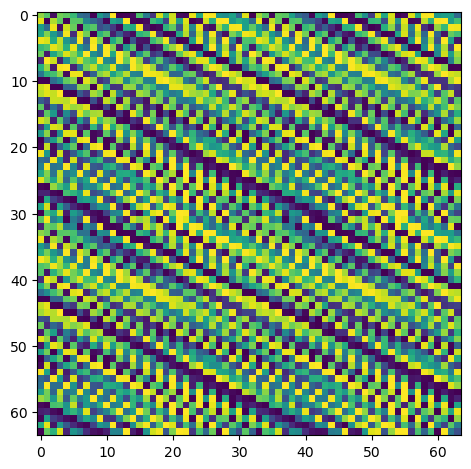

In [20]:
sample = 7
wave_data = WaveEquationDataset("training", 16, 256, 5, s=64)
input, label = wave_data.__getitem__(sample)
print("FFT input = ",input.shape)
modes = input.shape[2]
input = input.reshape(modes, input.shape[0], input.shape[1])
print(input[1].shape)
fig, ax = plt.subplots()
for i in range(modes):
    ax.imshow(input[i])
fig.tight_layout()
fig.show()

# Inference Wave & Darcy

In [24]:
index = 2
problem = Darcy(fno_architecture, device, batch_size,training_samples)
model = torch.load("/p/project/cexalab/john2/NeuralOperators/neural_operators/TrainedModels/FNO_darcy_tmp1/model.pkl", map_location=torch.device('cpu'))

for step, (input_batch, output_batch) in enumerate(problem.val_loader):
            output_pred_batch = model(input_batch)
            print("input, output, prediction = ",input_batch.shape, output_batch.shape, output_pred_batch.shape)
            for i in range(index,index+1):
                x = input_batch[i]
                y = output_batch[i]
                z = output_pred_batch[i].detach().numpy()
                # print(x.shape,y.shape, z.shape)
                plot_data(x, y,index,example,z,out=True)
                print(np.linalg.norm(y-z))
            break
            
            
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(1, 2, 1)
plt.plot(x.reshape((64,64))[5],label="x")
ax.set_title('x')
ax = fig.add_subplot(1, 2, 2)
plt.plot(y.reshape((64,64))[5],label="y")
# ax.set_title('y')
# ax = fig.add_subplot(1, 3, 3)
plt.plot(z.reshape((64,64))[5],label="z")
# ax.set_title('z')
plt.legend()
fig.suptitle(f'Visualizing input sample {index} for Wave problem')
fig.tight_layout()
fig.show()

## Plot Wave & Darcy

In [1]:
def plot_data(x, y, index, example, z=0, out=False):
    if out:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Input y')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(y.squeeze())
        ax.set_title('Model Prediction')
        fig.suptitle(f'Visualizing sample {index} of {example} problem', y=0.76)
        fig.tight_layout()
        fig.show()
            
    else: 
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Ouput y')
        fig.suptitle(f'Visualizing input sample {index} for {example} problem', y=0.75)
        fig.tight_layout()
        fig.show()